---

<center>

#

# Tópicos em Ciência de Dados
### Prof. Dr. Denis Mayr Lima Martins

### Pontifícia Universidade Católica de Campinas

<img src="https://www.puc-campinas.edu.br/wp-content/uploads/2022/06/logo-puc.png" height=100px/>

</center>

---

# Mecanismos de Atenção

Exploraremos o mecanismo de atenção que constitui a espinha dorsal dos LLMs. Estes mecanismos, e mais especificamente a self‑attention, permite que cada token de uma sequência se relacione contextualmente com os demais tokens, gerando representações altamente informativas. 

No contexto de Transformers, essa operação é realizada de forma paralela, escalada por múltiplas "heads" e otimizada pela normalização por $\sqrt{d_k}$. A partir da teoria dos pesos de atenção, a arquitetura GPT e variantes modernas (BERT, T5, etc.) alcançam performance sem precedentes em tarefas de geração, compreensão e tradução automática. 

Este notebook guia o estudante desde os fundamentos matemáticos da atenção até a implementação prática em NumPy, culminando na aplicação do algoritmo em dados simulados para ilustrar como a atenção influencia a representação dos tokens.

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
SEED = 1234
np.random.seed(SEED)

In [27]:
def get_embeddings(word):
    return np.random.rand(3)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

## Tokenização e Embeddings

In [28]:
sentence = "The cat hunts mouse"
words = sentence.split()
embeddings = np.array([get_embeddings(word) for word in words])

## Queries, Keys e Values

Calcular  **projeção linear**: `Q`, `K` e `V` são obtidos multiplicando as embeddings pelos pesos correspondentes (`W_Q`, `W_K`, `W_V`).  

In [29]:
WQ = np.random.random(embeddings.shape)
Q = np.array(embeddings).dot(WQ.T)
Q

array([[0.73634365, 0.42647927, 0.85683087, 0.32620017],
       [1.19358144, 0.83688612, 1.39485002, 0.64264091],
       [1.11520082, 0.57175117, 1.27103597, 0.58396596],
       [1.03917841, 0.67847982, 1.17557442, 0.75079734]])

In [30]:
WK = np.random.random(embeddings.shape)
K = np.array(embeddings).dot(WK.T)
K

array([[0.75780912, 0.59683623, 0.78892439, 0.77407585],
       [1.34918327, 1.02141999, 1.24144089, 0.85427868],
       [1.16087731, 1.01643544, 1.35860721, 1.27956075],
       [1.24943877, 1.08885856, 1.31923949, 0.73091859]])

In [31]:
WV = np.random.random(embeddings.shape)
V = np.array(embeddings).dot(WV.T)
V

array([[0.81080848, 0.2920271 , 0.68920257, 0.37484638],
       [1.01372893, 0.81102414, 0.725672  , 0.60567394],
       [1.22574627, 0.47592542, 1.1239937 , 0.72011269],
       [0.74409112, 0.91022723, 0.58086821, 0.76392111]])

## Similaridade entre Q e V: Scaled Dot Product

 - Calcula a similaridade escalar entre cada par de tokens: $\text{score} = \frac{Q K^\top}{\sqrt{d_k}}$.  
- O denominador normaliza o produto interno, evitando valores muito grandes que poderiam saturar a softmax.

In [32]:
similarity_scores = Q.dot(K.T)
similarity_scores

array([[1.74102466, 2.77144772, 2.86978282, 2.7531828 ],
       [3.00187487, 4.7457906 , 4.95359371, 4.71241696],
       [2.64113639, 4.16539406, 4.34981804, 4.11956372],
       [2.70105363, 4.19585129, 4.45382426, 4.13679429]])

In [33]:
dim = np.array(Q.shape[0]**0.5)
dim

array(2.)

In [34]:
scaled_similarity_scores = Q.dot(K)/dim
scaled_similarity_scores

array([[1.26782464, 1.05059507, 1.35240051, 1.13455545],
       [2.22790493, 1.84235246, 2.36172036, 1.94668503],
       [1.9108265 , 1.58868634, 2.043417  , 1.70244209],
       [2.00283274, 1.6628199 , 2.12487558, 1.71850219]])

### Por que escalar os valores do produto escalar?

In [35]:
Q.var(), K.var(), similarity_scores.var()

(np.float64(0.09385167529024863),
 np.float64(0.06090284043555731),
 np.float64(0.8970449776197686))

In [36]:
# Similaridade com variância em escala semelhante a Q e K
Q.var(), K.var(), scaled_similarity_scores.var()

(np.float64(0.09385167529024863),
 np.float64(0.06090284043555731),
 np.float64(0.14133630407607445))

## Masked (Causal) Attention


In [37]:
mask = np.tril(np.ones(scaled_similarity_scores.shape))
mask[mask == 0] = -np.inf
mask[mask == 1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [38]:
masked_scores = scaled_similarity_scores + mask
masked_scores

array([[1.26782464,       -inf,       -inf,       -inf],
       [2.22790493, 1.84235246,       -inf,       -inf],
       [1.9108265 , 1.58868634, 2.043417  ,       -inf],
       [2.00283274, 1.6628199 , 2.12487558, 1.71850219]])

## Pesos de Atenção: Probabilidades com Softmax

- Converte os scores em probabilidades (pesos de atenção) com $\text{attention} = \text{softmax}(\text{score})$.  
- Cada linha da matriz de pesos soma‑se a 1, interpretando‑se como a distribuição de "atenção" que o token dá aos demais tokens.

In [39]:
attention_weights = softmax(masked_scores)
attention_weights

array([[0.13158609, 0.        , 0.        , 0.        ],
       [0.34369052, 0.38290533, 0.        , 0.        ],
       [0.25030074, 0.29711571, 0.47964661, 0.        ],
       [0.27442264, 0.31997895, 0.52035339, 1.        ]])

In [40]:
attention_weights.sum(axis=0)

array([1., 1., 1., 1.])

## Self-Attention: Combinação com Values

| Representação Gráfica | Descrição |Fórmulação|
|:----------------------|:----------|:---------|
| <img src="https://machinelearningmastery.com/wp-content/uploads/2021/09/tour_3.png" height="300px"/>| A saída final para cada posição é uma <br> média ponderada dos vetores `V`, <br> usando os pesos calculados.|$\text{Attention}(Q, K, V) = \operatorname{Softmax}\!\left(\frac{Q\,K^{\top}}{\sqrt{d_k}}\right)\, V$|

In [41]:
self_attention_output = attention_weights.dot(V.T)
self_attention_output

array([[0.10669112, 0.13339263, 0.16129116, 0.09791204],
       [0.39048592, 0.65895449, 0.60351176, 0.60426792],
       [0.62028548, 0.84277124, 0.98732989, 0.73530084],
       [1.04942201, 1.52098066, 1.79364527, 1.56162686]])

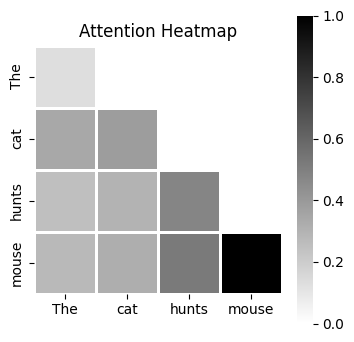

In [42]:
plt.figure(figsize=(4, 4))
sns.heatmap(
    attention_weights, 
    xticklabels=words, 
    yticklabels=words, 
    square=True, 
    linewidth=1,
    cmap="binary",
    )
plt.title("Attention Heatmap")
plt.show()

## Encapsulando Self-Attention em uma função completa

In [43]:
def self_attention(embeddings):
    """
    Aplica o mecanismo de *self‑attention* a um conjunto de embeddings.

    Parameters
    ----------
    embeddings : numpy.ndarray
        Matriz de forma (n_tokens, d_model) contendo os vetores de entrada. 
        Cada linha corresponde ao embedding de um token da sequência.

    Returns
    -------
    output : numpy.ndarray
        Representação contextualizada de cada token. A matriz tem a mesma
        dimensionalidade que `embeddings` e reflete a soma ponderada dos
        vetores de valor (V) segundo os pesos de atenção calculados.
        
    attention_weights : numpy.ndarray
        Matriz de pesos de atenção (n_tokens × n_tokens). Cada linha representa 
        uma distribuição de probabilidade sobre os tokens da sequência para o token
        correspondente.

    Notes
    -----
    1. **Geração das matrizes de projeção**  
       As matrizes `W_Q`, `W_K` e `W_V` são inicializadas aleatoriamente com a mesma
       forma que `embeddings`. Em uma implementação real, estas seriam parâmetros
       aprendidos.

    2. **Projeções**  
       - `Q = embeddings @ W_Q.T`  
       - `K = embeddings @ W_K.T`  
       - `V = embeddings @ W_V.T`  

    3. **Escalonamento do dot‑product**  
       O escalar `dim` é calculado como a raiz quadrada da dimensão de Q/K
       (i.e., `sqrt(d_model)`), evitando que os produtos internos cresçam demais
       e mantenham a softmax numericamente estável.

    4. **Máscara causal**  
       A matriz triangular inferior (`np.tril`) impede que um token “veja”
       tokens futuros, garantindo a causalidade em modelos autoregressivos.
       Valores fora da diagonal são definidos como `-inf` para anular sua
       contribuição após a softmax.

    5. **Softmax**  
       A função `softmax` (não mostrada aqui) transforma os scores mascarados
       em probabilidades que somam 1 por linha, formando os pesos de atenção.

    6. **Soma ponderada**  
       O produto final `output = attention_weights @ V.T` combina os vetores
       de valor segundo a distribuição aprendida, gerando as representações
       contextuais.

    7. **Limitações**  
       - As matrizes de pesos são aleatórias e não treinadas; portanto o
         resultado carece de significado prático sem treinamento supervisionado.
       - O código assume que todas as operações se realizam em CPU; para GPU,
         seria necessário adaptar a implementação usando `torch`.
    """
    # Cria as matrizes de pesos para os embeddings
    W_Q = np.random.random(embeddings.shape)
    W_K = np.random.random(embeddings.shape)
    W_V = np.random.random(embeddings.shape)

    # Cria Q, K e V
    Q = embeddings.dot(W_Q.T)
    K = embeddings.dot(W_K.T)
    V = embeddings.dot(W_V.T)

    # Calcula a dimensão para escalar o dot product
    dim = np.array(Q.shape[0]**0.5)

    # Calcula o produto escalar dos embeddings
    scores = Q.dot(K)/dim
    
    # Mascara os scores para evitar que tokens anteriores
    #  tenham informação de tokens futuros
    mask = np.tril(np.ones(scaled_similarity_scores.shape))
    mask[mask == 0] = -np.inf
    mask[mask == 1] = 0

    masked_scores = scaled_similarity_scores + mask


    # Aplica a softmax para obter os pesos de atenção
    attention_weights = softmax(masked_scores)
    
    # Calcula a soma ponderada dos embeddings
    output = np.dot(attention_weights, V.T)
    
    return output, attention_weights

In [44]:
output, attention_weights = self_attention(embeddings)

In [45]:
output

array([[0.03385798, 0.06795636, 0.05736033, 0.07451556],
       [0.34351927, 0.62852834, 0.56964175, 0.65636921],
       [0.44434504, 0.65118017, 0.75210792, 0.65922295],
       [1.44358935, 2.07266063, 2.31967164, 1.89220321]])

In [46]:
attention_weights

array([[0.13158609, 0.        , 0.        , 0.        ],
       [0.34369052, 0.38290533, 0.        , 0.        ],
       [0.25030074, 0.29711571, 0.47964661, 0.        ],
       [0.27442264, 0.31997895, 0.52035339, 1.        ]])

## Multi-Head Attention

| Representação Gráfica | Descrição |
|:--|:--:|
|  Cada cabeça de atenção pode focar em <br> padrões diferentes (ex.: sintaxe, semântica, dependências a longo prazo).| <img src="https://www.jeremyjordan.me/content/images/2023/05/multi-head-attention.png" height="200px" /> |

In [47]:
def multi_head_attention(embeddings, num_heads=2):
    """
    Aplica atenção multi‑cabeça (Multi‑Head Attention) em um conjunto de embeddings.

    A função divide o cálculo da atenção em `num_heads` sub‑modelos independentes,
    cada um produzindo uma representação distinta dos *queries*, *keys* e
    *values*.  As saídas individuais são concatenadas ao longo do eixo das
    características, gerando assim a projeção linear típica de uma camada
    multi‑cabeça.

    Parameters
    ----------
    embeddings : numpy.ndarray
        Tensor de entrada com forma ``(seq_len, d_model)`` onde
        *seq_len* é o tamanho da sequência (ex.: número de tokens)
        e *d_model* representa a dimensionalidade dos embeddings.
        O array deve ser do tipo `float` ou equivalente.
    num_heads : int, optional
        Número de cabeças de atenção.  Cada cabeça executa uma chamada a
        `self_attention(embeddings)` (uma função que deve retornar
        `(output, attention_weights)`).  
        O valor padrão é ``2``.

    Returns
    -------
    numpy.ndarray
        Tensor resultante da concatenação das saídas de todas as cabeças.
        A forma do retorno será ``(seq_len, num_heads * d_head)``,
        onde `d_head = d_model // num_heads`.  Se `num_heads` não for divisor
        exato de `d_model`, o último segmento pode ter dimensão menor.
    """
    head_outputs = []
    
    for _ in range(num_heads):
        output, _ = self_attention(embeddings)
        head_outputs.append(output)
    
    # Concatena as saídas de todas as cabeças
    return np.concatenate(head_outputs)

# Calcula a atenção multi‑cabeça
multi_head_output = multi_head_attention(embeddings)
print("Saída da MHA:\n", multi_head_output)
print("Shape:", multi_head_output.shape)

Saída da MHA:
 [[0.0994691  0.12105612 0.14553897 0.07938693]
 [0.5373246  0.60720947 0.87887178 0.51157984]
 [0.63374816 0.92723863 1.03750033 0.88338746]
 [1.59325631 2.0461638  2.57622858 1.79480785]
 [0.07135296 0.06906638 0.1300595  0.07347102]
 [0.37417981 0.41672593 0.62458525 0.36774487]
 [0.62391651 0.96509893 0.9720056  0.8616684 ]
 [1.52339959 1.95082781 2.45765866 1.69994613]]
Shape: (8, 4)


## Camada linear de saída

A camada linear que segue a concatenação das saídas da MHA serve fundamentalmente para **projetar** o vetor de dimensões ampliadas (produto do número de cabeças por dimensão de cada cabeça) de volta à dimensionalidade original do modelo (*d_model*). 

Essa projeção permite que as informações capturadas independentemente em cada cabeça sejam combinadas num único espaço sem aumentar a carga computacional nas camadas subsequentes. 

Além disso, ao aplicar pesos aprendidos e um viés, essa camada introduz capacidade de *mixer* entre os cabeças, facilitando a transmissão de dependências contextuais complexas, enquanto mantém o tamanho do modelo consistente para compatibilidade com as próximas etapas (normalização, feed‑forward, etc.).

In [48]:
def feedforward_network(x):
    """
    Aplica uma rede neural feed‑forward de duas camadas em um tensor de entrada.

    A função implementa a arquitetura clássica “two‑layer perceptron” (MLP) com
    ativação ReLU na camada oculta. Os pesos e vieses são gerados aleatoriamente
    a cada chamada, o que facilita demonstrações didáticas mas não é adequado
    para treinamento em produção.

    Parameters
    ----------
    x : numpy.ndarray
        Tensor de entrada de forma ``(batch_size, d_in)`` onde *d_in* corresponde à
        dimensionalidade da representação de cada amostra. O array deve ser do tipo
        `float` ou equivalente.

    Returns
    -------
    numpy.ndarray
        Saída da rede com forma ``(batch_size, d_out)``, onde  
        ``d_out = d_in`` (o número de neurônios na camada de saída é igual ao
        dimensionalidade de entrada). Cada elemento corresponde à projeção linear
        do vetor de características após a aplicação da função ReLU.

    Notes
    -----
    - Os pesos e vieses são inicializados com valores aleatórios em ``[0, 1)``
      usando `np.random.rand`. Em cenários reais esses parâmetros seriam
      aprendidos via back‑propagation.
    - A camada oculta possui ``2 * d_in`` neurônios; o fator 2 pode ser ajustado
      de acordo com a complexidade desejada.
    """
    # Rede feed‑forward simples com uma camada oculta
    # Pesos da camada oculta
    W1 = np.random.rand(x.shape[1], x.shape[1] * 2)
    # Viéses da camada oculta
    b1 = np.random.rand(x.shape[1] * 2)              
    # Pesos da camada de saída
    W2 = np.random.rand(x.shape[1] * 2, x.shape[1])  
    # Viéses da camada de saída
    b2 = np.random.rand(x.shape[1])                  
    
    # Ativação ReLU
    hidden_layer = np.maximum(0, np.dot(x, W1) + b1)  
    output_layer = np.dot(hidden_layer, W2) + b2
    
    return output_layer

# Passa as features de MHA pela rede (FC)
final_output = feedforward_network(multi_head_output)
print("Saída Final:\n", final_output)
print("Shape:", final_output.shape)

Saída Final:
 [[ 3.17695674  2.98664348  2.5831752   4.4084341 ]
 [ 8.88671905  7.90873057  7.94046735 11.94089099]
 [11.44750925 10.12335968 10.26517694 15.20395404]
 [23.87670969 20.82116613 21.93764431 31.59915826]
 [ 2.8737637   2.73318301  2.29232096  4.00703874]
 [ 6.81660573  6.12905012  5.99316222  9.20739846]
 [11.32358161 10.00487874 10.15262762 15.0336155 ]
 [22.84596507 19.93152506 20.97784673 30.24971987]]
Shape: (8, 4)


# Próximos Passos

- Modifique o código acima para adicionar um tokenizer conforme visto nas aulas anteriores
    - Tratamento de pontuação
    - Tratamento de palavras desconhecidas
    - Criação de Token IDs
- Implemente via numpy positional enconding para os tokens.
    - Use como base a implementação em [Machine Learning Mastery](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/).
    - $P(k, 2i) = \sin\Big(\frac{k}{n^{2i/d}}\Big)$
    - $P(k, 2i+1) = \cos\Big(\frac{k}{n^{2i/d}}\Big)$
- Modifique o código acima para utilizar modelos de embeddings mais robustos (Word2Vec, BPE).